# MobileNet

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

print("tensor flow version : " + tf.__version__)

Num GPUs Available:  1
tensor flow version : 2.2.0


## Fine-tune MobileNet on cats and dogs

### Image preparation

The images included in the data/cats-and-dogs directory are a random subset of the full cat and dog data set from the following Kaggle competition: https://www.kaggle.com/c/dogs-vs-cats/data

In [3]:
train_path = './data/cats-and-dogs/train'
valid_path = './data/cats-and-dogs/valid'
test_path = './data/cats-and-dogs/test'

In [4]:
train_batch_size = 100
val_batch_size = 50
test_batch_size = 100

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=train_batch_size)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=val_batch_size)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=test_batch_size, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [5]:
print(train_batches.n)
print(valid_batches.n)
print(test_batches.n)

num_train_samples = train_batches.n
num_val_samples = valid_batches.n
num_test_samples = test_batches.n

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
test_steps = np.ceil(num_val_samples / val_batch_size)


1000
200
100


In [6]:
# assert train_batches.n == 40
# assert valid_batches.n == 16
# assert test_batches.n == 10
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

### Modify Model

In [7]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [8]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [9]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {'non_trainable_params': non_trainable_params, 'trainable_params': trainable_params}

In [10]:
params = count_params(mobile)
assert params['non_trainable_params'] == 21888
assert params['trainable_params'] == 4231976

In [11]:
x = mobile.layers[-6].output
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=predictions)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [13]:
params = count_params(model)
assert params['non_trainable_params'] == 21888
assert params['trainable_params'] == 3209026

In [14]:
for layer in model.layers[:-5]:
    layer.trainable = False

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [16]:
params = count_params(model)
assert params['non_trainable_params'] == 2178240
assert params['trainable_params'] == 1052674

In [17]:
valid_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

### Train the model

In [18]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(x=train_batches, steps_per_epoch=train_steps, validation_data=valid_batches, validation_steps=val_steps, epochs=30, verbose=1)

Epoch 1/30
10/10 [==============================] - 4s 364ms/step - loss: 0.4244 - accuracy: 0.8010 - val_loss: 1.4786 - val_accuracy: 0.5300
Epoch 2/30
10/10 [==============================] - 3s 346ms/step - loss: 0.0819 - accuracy: 0.9720 - val_loss: 1.1976 - val_accuracy: 0.6250
Epoch 3/30
10/10 [==============================] - 3s 340ms/step - loss: 0.0529 - accuracy: 0.9810 - val_loss: 0.8248 - val_accuracy: 0.7100
Epoch 4/30
10/10 [==============================] - 3s 334ms/step - loss: 0.0294 - accuracy: 0.9910 - val_loss: 0.5958 - val_accuracy: 0.7800
Epoch 5/30
10/10 [==============================] - 3s 339ms/step - loss: 0.0218 - accuracy: 0.9960 - val_loss: 0.4313 - val_accuracy: 0.8300
Epoch 6/30
10/10 [==============================] - 3s 339ms/step - loss: 0.0166 - accuracy: 1.0000 - val_loss: 0.3266 - val_accuracy: 0.8500
Epoch 7/30
10/10 [==============================] - 3s 335ms/step - loss: 0.0138 - accuracy: 0.9990 - val_loss: 0.2516 - val_accuracy: 0.8700
Epoch 

In [20]:
assert model.history.history.get('accuracy')[-1] > 0.95

### Predict cats and dogs

In [21]:
test_labels = test_batches.classes

In [22]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [23]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

In [39]:
# predictions = model.predict(x=test_batches, steps=10, verbose=0)
predictions = model.predict(x=test_batches, steps = 1, verbose = 1)

1/1 [==============================] - 0s 961us/step


In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
#rounded_predictions = np.argmax(predictions, axis=-1)
#cm = confusion_matrix(y_true=test_labels, y_pred=rounded_predictions)
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

# cm = confusion_matrix(y_true=test_labels, y_pred=np.round(predictions[:,0]))

In [42]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[48  2]
 [ 3 47]]


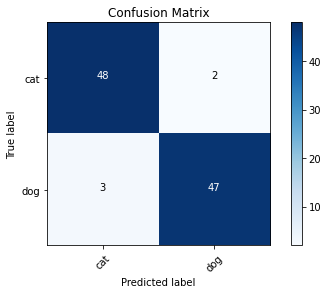

In [43]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [44]:
assert np.sum(test_labels == predictions.argmax(axis=1)) > 8

In [45]:
def print_results(cm):
    tp = cm[0, 0]
    tn = cm[1, 1]
    fn = cm[0, 1]
    fp = cm[1, 0]
    
    accuracy = ((tp + tn) / (tp + tn + fp + fn)) * 100
    
    sensitivity = (tp / (tp + fn)) * 100
    
    specificity = (tn / ( tn + fp )) * 100
    
    print ('Accuracy: ',  accuracy)

    print ('Sensitivity: ', sensitivity)
    
    print ('Specificity: ',  specificity)

In [46]:
print_results(cm)

Accuracy:  95.0
Sensitivity:  96.0
Specificity:  94.0


In [47]:
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()
    
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    
    plt.show()

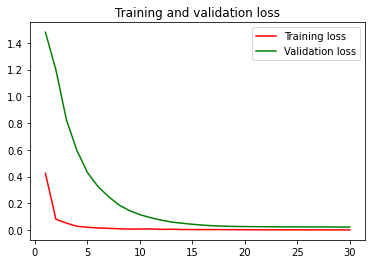

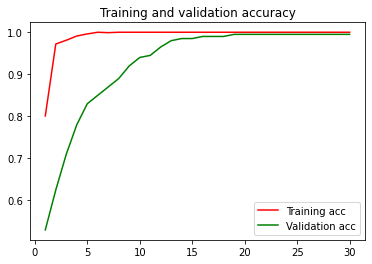

<Figure size 432x288 with 0 Axes>

In [48]:
plot_training_curves(history)

In [34]:
# # export model
# import pickle

# pickle.dump(model, open('./mobilenet.pkl', 'wb'))

In [51]:
MODEL_FILEPATH= './models/mobilenet_model.h5'
# Save model
if os.path.isfile(MODEL_FILEPATH) is False:
    model.save(MODEL_FILEPATH)

In [52]:
import pandas as pd
# save to json:  
hist_json_file = './models/history_mobilenet.json'
hist_df = pd.DataFrame(history.history) 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)